# Finetuning Torchvision Models


- Pytorch model에서 finetuning을 어떻게 하는지 학습한다.
- finetune / feature extraction을 수행

<br/>

두개의 transfer learning 메소드는 몇가지 과정을 따름

- pretrained model 초기화
- 새로운 데이터셋에 맞춰 출력 lyaer를 조정
- optimization algorithm을 종우하머
- 학습

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  0.4.1
Torchvision Version:  0.2.1


# Inputs

- pretrained model을 사용할 때, input parameter에 대해서 알아봄
- *hymenoptera_data* dataset을 사용(**bees / ants**)

`torchvision`에서 제공되는 pretrained model 리스트는 다음과 같음.  
    
<br/>

```
[resnet, alexnet, vgg, squeezenet, densenet, inception]

```

<br/>

- `num_classes` : dataset의 class 개수
- `batch_size` : 학습시의 batch size
- `num_epochs` : 학습시의 epoch 수
- `feature_extract` : `True`인 경우에는, feature extractor로만 사용가능; 마지막 layer만 업데이트 됨. 
    - (파라미터 trainable or non-trainable)



In [2]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./data/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Helper Function

helper function을 만들어보자.

## Model Training and Validation Code

- `train_model`함수는 model을 인자로 받고 training과 validation을 핸들링한다.
- 이때 필요한 파라미터는 `model`, `dataloaders,`, `criterion`, `optimizer`, `num_epochs`, `is_inception`
    - `is_inception` flag는 *Inception v3* 모델을 수용할 때, 사용한다.
- 해당 helper function은 정해진 epoch안에 제일 성능이 잘나오는 모델을 반환한다.

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

# Set Model Parameters' .requires_grad attribute

- 이미 모두가 알고있듯이 `.requires_grad`가 `True`몇 finetune, `False`면 feature extractor가 된다.

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Initialize and Reshape the Networks

# Resnet

Resnet의 FC layer구조는 아래와 같음.  

```python
(fc): Linear(in_features=512, out_features=1000, bias=True)
```

이를 다음과 같이 변경함  
```python
model.fc = nn.Linear(512, num_classes)
```

# Alexnet

Alexnet 구조는 아래와 같음  
```python
(classifier): Sequential(
    ...
    (6): Linear(in_features=4096, out_features=1000, bias=True)
 )
```

이를 다음과 같이 변경해줌

```python
model.classifier[6] = nn.Linear(4096,num_classes)
```

# Squeezenet

```python
(classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
    (2): ReLU(inplace)
    (3): AvgPool2d(kernel_size=13, stride=1, padding=0)
 )
```

```python
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
```


# Densenet
```python
(classifier): Linear(in_features=1024, out_features=1000, bias=True)
```

```python
model.classifier = nn.Linear(1024, num_classes)
```

# Inception v3
```python
(AuxLogits): InceptionAux(
    ...
    (fc): Linear(in_features=768, out_features=1000, bias=True)
 )
 ...
(fc): Linear(in_features=2048, out_features=1000, bias=True)
```

```python
model.AuxLogits.fc = nn.Linear(768, num_classes)
model.fc = nn.Linear(2048, num_classes)
```

In [5]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

/usr/local/lib/python3.6/dist-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/usr/local/lib/python3.6/dist-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /home/keti-1080ti/.torch/models/squeezenet1_0-a815701f.pth
100%|██████████| 5017600/5017600 [00:05<00:00, 972198.61it/s] 


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 32, kerne

# Load Data

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


# Create the Optimizer

In [7]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


# Run Training and Validation Step

In [8]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------
train Loss: 0.5249 Acc: 0.7828
val Loss: 0.5593 Acc: 0.8366

Epoch 1/14
----------
train Loss: 0.3089 Acc: 0.8893
val Loss: 0.3577 Acc: 0.8889

Epoch 2/14
----------
train Loss: 0.2382 Acc: 0.8934
val Loss: 0.3255 Acc: 0.9150

Epoch 3/14
----------
train Loss: 0.1815 Acc: 0.9303
val Loss: 0.3479 Acc: 0.9085

Epoch 4/14
----------
train Loss: 0.1894 Acc: 0.9098
val Loss: 0.3635 Acc: 0.9216

Epoch 5/14
----------
train Loss: 0.1244 Acc: 0.9467
val Loss: 0.3798 Acc: 0.9281

Epoch 6/14
----------
train Loss: 0.1487 Acc: 0.9549
val Loss: 0.3674 Acc: 0.9346

Epoch 7/14
----------
train Loss: 0.1699 Acc: 0.9016
val Loss: 0.3662 Acc: 0.8954

Epoch 8/14
----------
train Loss: 0.1496 Acc: 0.9467
val Loss: 0.3674 Acc: 0.9216

Epoch 9/14
----------
train Loss: 0.2392 Acc: 0.9057
val Loss: 0.3648 Acc: 0.9281

Epoch 10/14
----------
train Loss: 0.1489 Acc: 0.9303
val Loss: 0.3343 Acc: 0.9216

Epoch 11/14
----------
train Loss: 0.1184 Acc: 0.9426
val Loss: 0.3438 Acc: 0.9281

Ep

# Comparison with Model Trained from Scratch

Epoch 0/14
----------


/usr/local/lib/python3.6/dist-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/usr/local/lib/python3.6/dist-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


train Loss: 0.7080 Acc: 0.4467
val Loss: 0.6931 Acc: 0.4575

Epoch 1/14
----------
train Loss: 0.6931 Acc: 0.5369
val Loss: 0.6931 Acc: 0.4575

Epoch 2/14
----------
train Loss: 0.6931 Acc: 0.5205
val Loss: 0.6931 Acc: 0.4575

Epoch 3/14
----------
train Loss: 0.6931 Acc: 0.5287
val Loss: 0.6931 Acc: 0.4575

Epoch 4/14
----------
train Loss: 0.6930 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 5/14
----------
train Loss: 0.6926 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4837

Epoch 6/14
----------
train Loss: 0.6913 Acc: 0.4959
val Loss: 0.6919 Acc: 0.5621

Epoch 7/14
----------
train Loss: 0.6912 Acc: 0.4959
val Loss: 0.6931 Acc: 0.4575

Epoch 8/14
----------
train Loss: 0.6931 Acc: 0.5328
val Loss: 0.6931 Acc: 0.4575

Epoch 9/14
----------
train Loss: 0.6931 Acc: 0.5287
val Loss: 0.6931 Acc: 0.4575

Epoch 10/14
----------
train Loss: 0.6931 Acc: 0.5738
val Loss: 0.6931 Acc: 0.4575

Epoch 11/14
----------
train Loss: 0.6931 Acc: 0.5533
val Loss: 0.6931 Acc: 0.4575

Epoch 12/14
----------
t

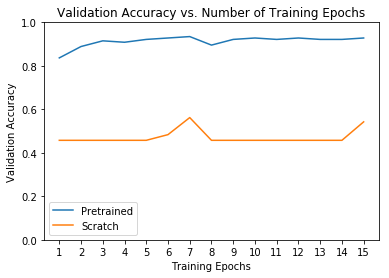

In [9]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

# Final Thoughts and Where to Go Next